# More convolutional neural network examples

This Notebook presents two examples using various modern ConvNets for image classification. It involves many of the techniques used in real-world projects, including:

- Creating datasets from images stored in the file system
- Using image augmentation
- Utilizing batch normalization and dropout layers
- Employing residual connections

Let's get started.

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.functional as F
import torchvision
from torchvision import datasets, transforms
import lightning as L
from torchmetrics import Accuracy
from torch.utils.data import random_split, DataLoader
from torchinfo import summary
import matplotlib.pyplot as plt

torch.random.manual_seed(17);

## Dogs vs cats
Our first example is an attempt to distinguish between dogs and cats. This is a binary classification task, where the goal is to categorize given images of dogs and cats into either the DOG or CAT category.

### Fetching and preparing the data
First we get the data by downloading it from Kaggle at https://www.kaggle.com/c/dogs-vs-cats/data. You will need to have an account to do so. You will also need the following package installed.

In [2]:
! pip install opendatasets --upgrade --quiet

Next, ensure that you have a valid Kaggle account with a verified phone number. Since this dataset is part of a competition, you'll need to join the competition and accept its rules before you can download the data.

To proceed, go to your account settings (click the avatar icon in the top right corner, then click your profile, and go to the Account tab). In the API section, click on the 'Create New Token' button. This action will download a 'kaggle.json' file. Save this file as it contains both your username and your key. You will be prompted to enter both when you run the following cell.

In [3]:
import opendatasets as od

data_path = './datasets'

dataset_url = 'https://www.kaggle.com/c/dogs-vs-cats/data'
od.download(dataset_url, data_dir=data_path)

Skipping, found downloaded files in "./datasets/dogs-vs-cats" (use force=True to force download)


This process may take a few minutes, depending on whether you've already downloaded the data or not. If you run the code a second time and the data is already downloaded, it won't be downloaded again. **Once downloaded, you need to unzip the `train.zip` file into the same folder.** You can do that either manually or by uncommenting and running the command below (if your OS supports it).

In [4]:
# unzip train.zip



The downloaded data includes a `train` sub-folder. We'll extract the images from this sub-folder, copy them, and split them into three sets: training, validation, and testing. These sets will be placed under a new `processed` folder with the following directory structure:

```
- datasets
    - dogs-vs-cats
        - processed
            - train
                - cat
                    ...files go here...
                - dog
                    ...files go here...
            - validation
                - cat
                    ...files go here...
                - dog
                    ...files go here...
            - test
                - cat
                    ...files go here...
                - dog
                    ...files go here...
```

This structure is commonly used in image classification problems, including not only the split of images into sets but also their actual labels (cat or dog).

To speed up this notebook, we'll use only the first 11 thousand dog images, split as follows: 8000 for training, 1500 for validation, and another 1500 for testing. The same applies to cats. Adjust the source `src_dir` and destination `dest_dir` paths in the code below to match your actual paths.

In [5]:
import os, shutil, pathlib

src_dir = pathlib.Path("./datasets/dogs-vs-cats/train")
dest_dir = pathlib.Path("./datasets/dogs-vs-cats/processed")

if not os.path.exists(dest_dir):
    def make_subset(subset_name, start_index, end_index):
        for category in ("cat", "dog"):
            dir = dest_dir / subset_name / category
            os.makedirs(dir)
            fnames = [ f"{category}.{i}.jpg" for i in range(start_index, end_index) ]
            for fname in fnames:
                shutil.copyfile(src=src_dir / fname,
                                dst=dir / fname)
    
    make_subset("train", start_index=0, end_index=8000)
    make_subset("validation", start_index=8000, end_index=9500)
    make_subset("test", start_index=9500, end_index=11000)
else:
    print("Skipping!", dest_dir, "already exists.")

Skipping! datasets/dogs-vs-cats/processed already exists.


Let's plot a couple of the training images:

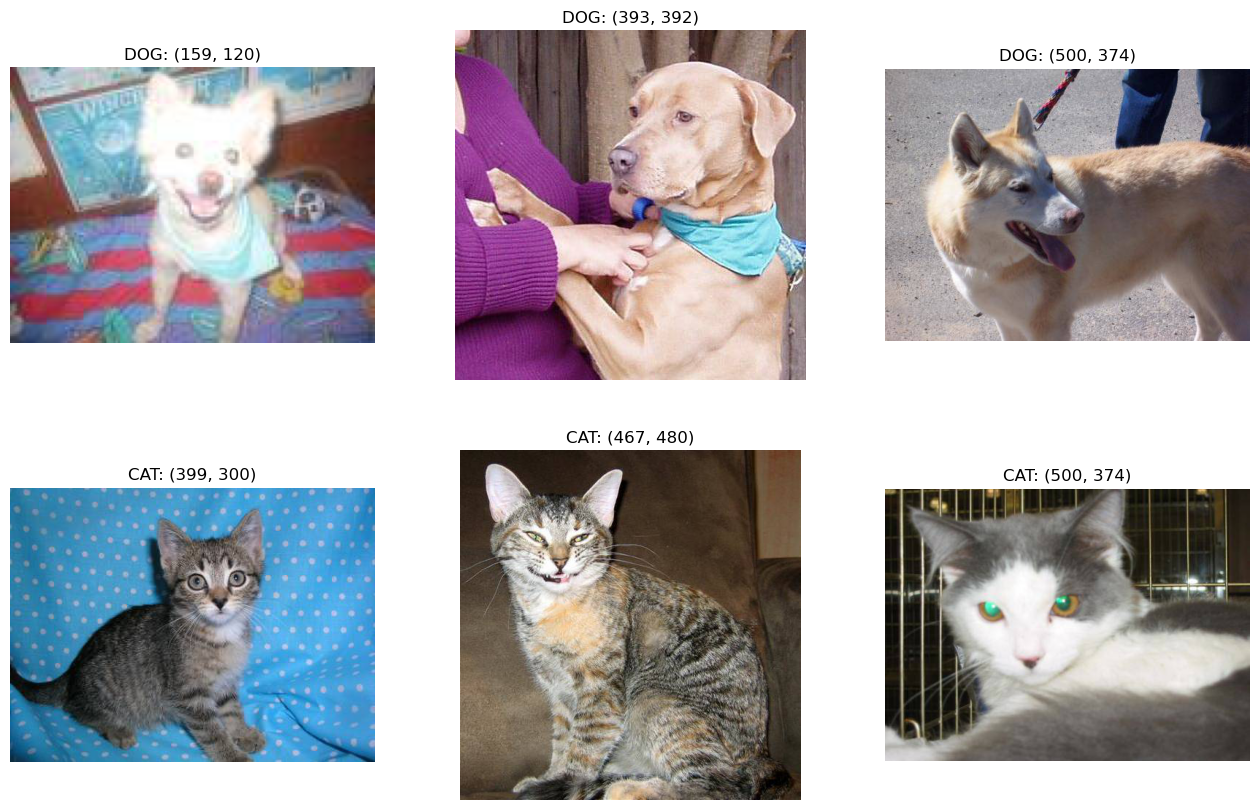

In [6]:
from PIL import Image
import glob 

fig = plt.figure(figsize=(16, 10))

for i, cls in enumerate(['dog', 'cat']):
    image_path_list= glob.glob(f"{dest_dir}/train/{cls}/*.jpg")
    for j in range(3):
        image_path = image_path_list[j]
        with Image.open(image_path) as f:
            plt.subplot(2, 3, 3 * i + j + 1)
            plt.imshow(f) 
            plt.title(f"{cls.upper()}: {f.size}")
            plt.axis("off")

The images, as you can see, are of different sizes . We need to run a few transformations on these images to make them have same size and convert them into tensors. This is easily done using `torchvision.transforms` during the creation of the dataset. Here are these basic transforms:

In [7]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

basic_transforms = transforms.Compose([
    transforms.Resize(size=(96, 96)),
    transforms.ToTensor()
])

Next, we use the `torchvision.datasets.ImageFolder` class to create training, validation, and testing datasets. This class simplifies the process by directly generating PyTorch datasets from the previously organized directory structure.

In [8]:
ds_train = datasets.ImageFolder(f"{dest_dir}/train", transform=basic_transforms)
ds_val = datasets.ImageFolder(f"{dest_dir}/validation", transform=basic_transforms)
ds_test = datasets.ImageFolder(f"{dest_dir}/test", transform=basic_transforms)

len(ds_train), len(ds_val), len(ds_test)

(16000, 3000, 3000)

As you can see, the training has 16,000 images: 8,000 for dogs and and another 8,000 for cats. Here is the shape of a transformed training image. 

In [9]:
ds_train[0][0].shape

torch.Size([3, 96, 96])

And here are the two classes (labels) of this data:

In [10]:
ds_train.classes

['cat', 'dog']

Let's plot some of the transformed training images to make sure the transformations above worked as expected.

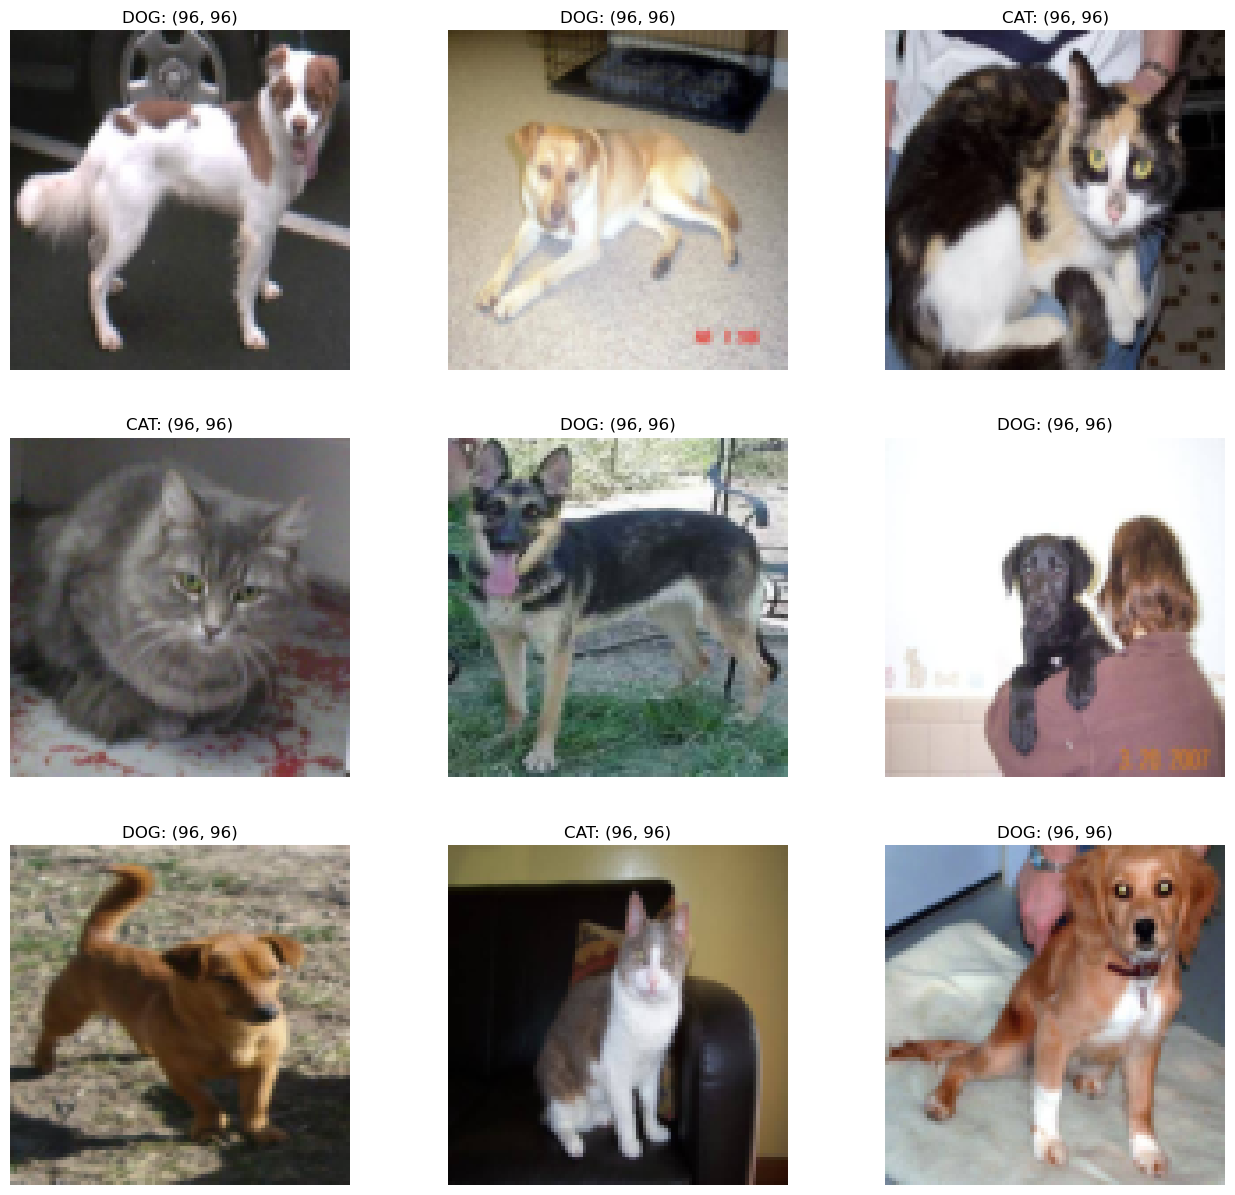

In [11]:
fig = plt.figure(figsize=(16, 15))

for i, j in enumerate(torch.randint(0, 16000, size=(1, 9)).squeeze()):
    plt.subplot(3, 3, i + 1)
    plt.imshow(ds_train[j][0].permute(1, 2, 0)) 
    plt.title(f"{ds_train.classes[ds_train[j][1]].upper()}: {tuple(ds_train[j][0].shape[1:])}")
    plt.axis("off")

As you can see, the images in these sets are resized to 96 by 96 pixels. Now, let's create the corresponding data loaders. Note that only the training data loader needs to shuffle, and we'll use a batch size of 128 images.

In [12]:
dl_train = DataLoader(ds_train, batch_size=128, shuffle=True, num_workers=4, persistent_workers=True, drop_last=True)
dl_val = DataLoader(ds_val, batch_size=128, shuffle=False, num_workers=4, persistent_workers=True)
dl_test = DataLoader(ds_test, batch_size=128, shuffle=False, num_workers=4, persistent_workers=True)

### Putting it all together in a lightning data module

We can train PyTorch models using the above data loaders. Alternatively, we can consolidate all the data fetching and preparation steps into a Lightning Data Module like this.

In [13]:
import opendatasets as od

class DogsVsCatsDataModule(L.LightningDataModule):
    def __init__(self, data_path='./datasets', transform = transforms.Compose([
            transforms.Resize(size=(96, 96)),
            transforms.ToTensor()
        ]), train_transform=None):
        super().__init__()

        self.data_path = data_path
        self.transform = transform
        self.train_transform = transform if train_transform is None else train_transform

    def make_subset(self, subset_name, start_index, end_index):
        for category in ("cat", "dog"):
            dir = self.dest_dir / subset_name / category
            os.makedirs(dir)
            fnames = [ f"{category}.{i}.jpg" for i in range(start_index, end_index) ]
            for fname in fnames:
                shutil.copyfile(src=self.src_dir / fname, dst=dir / fname)
                        
    def prepare_data(self):
        dataset_url = 'https://www.kaggle.com/c/dogs-vs-cats/data'
        od.download(dataset_url, data_dir=self.data_path)
        
        self.src_dir = pathlib.Path(self.data_path + "/dogs-vs-cats/train")
        self.dest_dir = pathlib.Path(self.data_path + "/dogs-vs-cats/processed")
        
        if not os.path.exists(self.dest_dir):
            self.make_subset("train", start_index=0, end_index=8000)
            self.make_subset("validation", start_index=8000, end_index=9500)
            self.make_subset("test", start_index=9500, end_index=11000)
        else:
            print("Skipping!", self.dest_dir, "already exists.")
            
    def setup(self, stage=None):
        self.target_transform = transforms.Lambda(lambda y: torch.tensor([y]).float())
        
        self.ds_train = datasets.ImageFolder(f"{self.dest_dir}/train", transform=self.train_transform) 
        self.ds_val = datasets.ImageFolder(f"{self.dest_dir}/validation", transform=self.transform)
        self.ds_test = datasets.ImageFolder(f"{self.dest_dir}/test", transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.ds_train, batch_size=128, num_workers=4, shuffle=True, persistent_workers=True, drop_last=True)

    def val_dataloader(self):
        return DataLoader(self.ds_val, batch_size=128, num_workers=4, persistent_workers=True)

    def test_dataloader(self):
        return DataLoader(self.ds_test, batch_size=128, num_workers=4, persistent_workers=True)
    
dogs_vs_cats_dm = DogsVsCatsDataModule()

### Building a ConvNet model

Here is a simple ConvNet model with four repeated covolutional blocks. Each block is made of:
* A convolutional layer,
* A batchnorm layer, and
* A pooling layer

Here is the base module with all the training and validation steps.

In [14]:
class BaseModule(L.LightningModule):
    def __init__(self, lr=0.001):
        super().__init__()
        self.lr = lr
        
        self.train_accuracy = Accuracy(task="multiclass", num_classes=2)
        self.val_accuracy = Accuracy(task="multiclass", num_classes=2)
        self.test_accuracy = Accuracy(task="multiclass", num_classes=2)

    def _common_step(self, batch, batch_idx, accuracy, loss_lbl, accuracy_lbl):
        X, y = batch
        logits = self(X)
        loss = nn.functional.cross_entropy(logits, y)
        y_hat = torch.argmax(logits, dim=1)
        self.log(loss_lbl, loss, prog_bar=True)
        self.log(accuracy_lbl, accuracy(y_hat, y), prog_bar=True)
        return loss

    def training_step(self, batch, batch_idx):
        return self._common_step(batch, batch_idx, self.train_accuracy, "loss", "accuracy")

    def on_training_epoch_end(self):
        self.log("accuracy", self.train_accuracy.compute())
        self.train_accuracy.reset()
    
    def validation_step(self, batch, batch_idx):
        return self._common_step(batch, batch_idx, self.val_accuracy, "val_loss", "val_accuracy")

    def on_validation_epoch_end(self):
        self.log("val_accuracy", self.val_accuracy.compute())
        self.val_accuracy.reset()

    def test_step(self, batch, batch_idx):
        return self._common_step(batch, batch_idx, self.test_accuracy, "test_loss", "test_accuracy")

    def on_test_epoch_end(self):
        self.log("test_accuracy", self.test_accuracy.compute())
        self.test_accuracy.reset()
        
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

Using this base module, here is the ConvNet:

In [15]:
class DogsVsCatsModelV01 (BaseModule):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(128, 128, kernel_size=3),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.Dropout1d(p=.5),
            nn.Linear(2048, 512),
            nn.ReLU(),
            nn.Linear(512, 2)
        )

    def forward(self, x):
        return self.model(x)

model = DogsVsCatsModelV01()

And here is a summary of this model:

In [16]:
from torchinfo import summary
summary(model)

Layer (type:depth-idx)                   Param #
DogsVsCatsModelV01                       --
├─MulticlassAccuracy: 1-1                --
├─MulticlassAccuracy: 1-2                --
├─MulticlassAccuracy: 1-3                --
├─Sequential: 1-4                        --
│    └─Conv2d: 2-1                       896
│    └─BatchNorm2d: 2-2                  64
│    └─ReLU: 2-3                         --
│    └─MaxPool2d: 2-4                    --
│    └─Conv2d: 2-5                       18,496
│    └─BatchNorm2d: 2-6                  128
│    └─ReLU: 2-7                         --
│    └─MaxPool2d: 2-8                    --
│    └─Conv2d: 2-9                       73,856
│    └─BatchNorm2d: 2-10                 256
│    └─ReLU: 2-11                        --
│    └─MaxPool2d: 2-12                   --
│    └─Conv2d: 2-13                      147,584
│    └─BatchNorm2d: 2-14                 256
│    └─ReLU: 2-15                        --
│    └─MaxPool2d: 2-16                   --
│    └─Fla

And here is a plot of it:

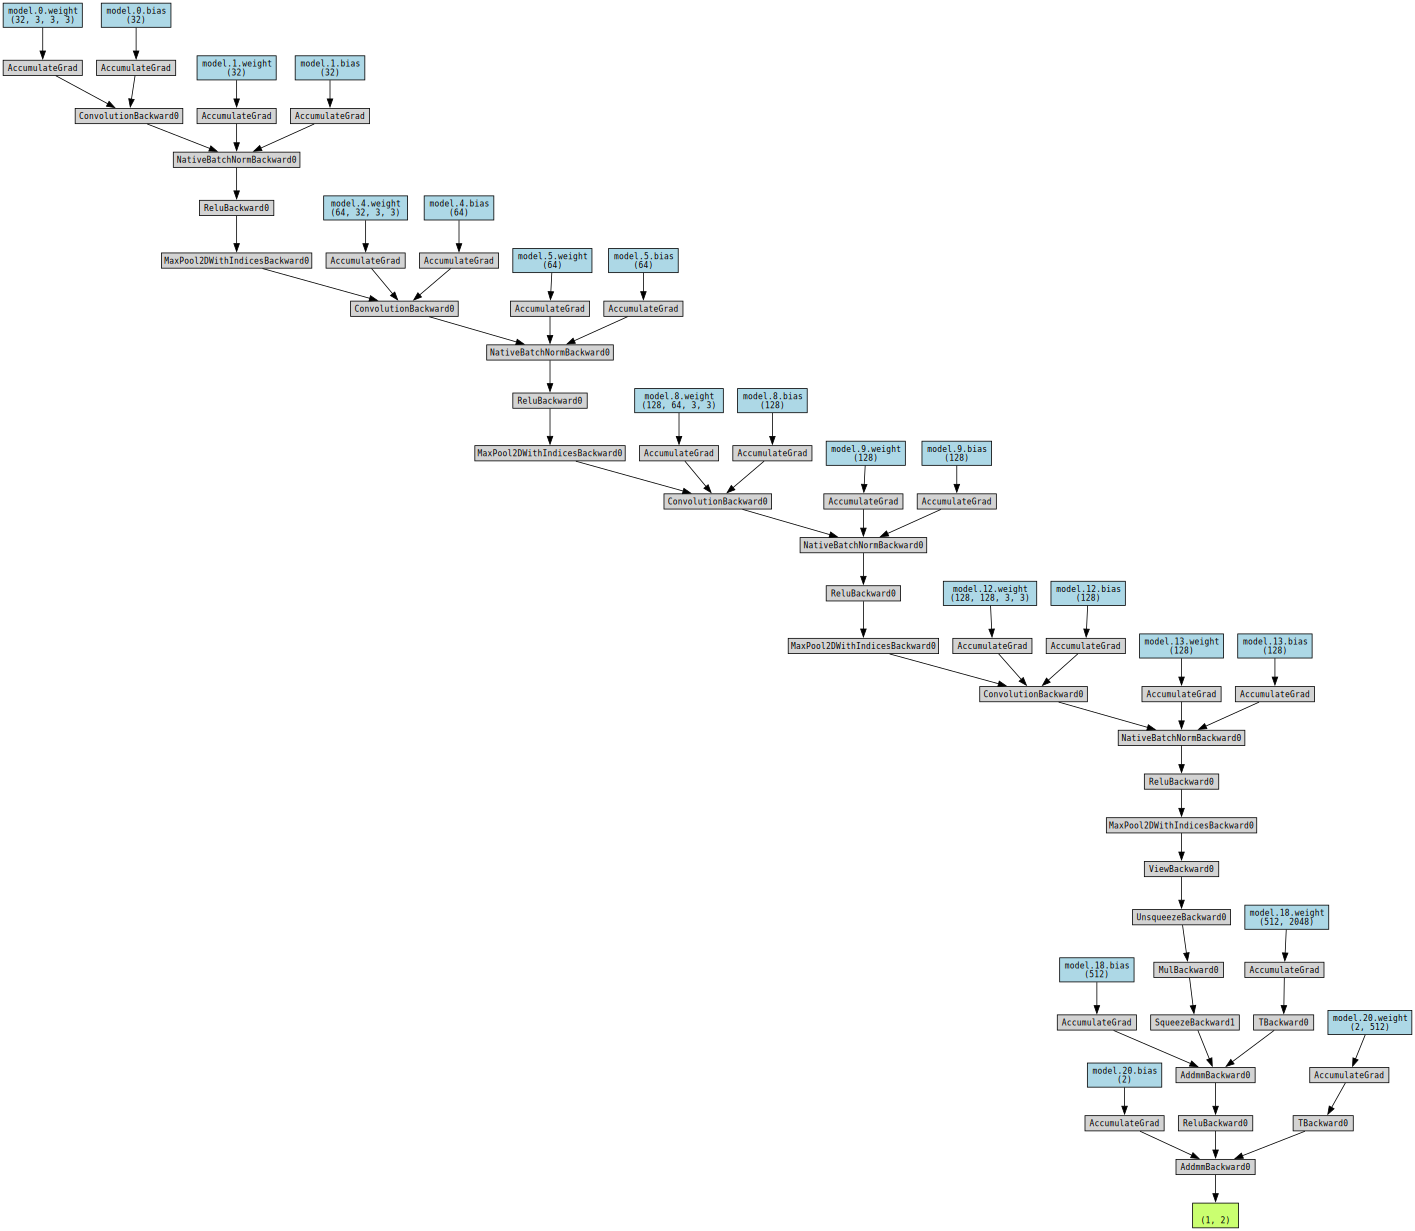

In [17]:
from torchviz import make_dot
make_dot(model(torch.ones(1, 3, 96, 96)), params=dict(model.named_parameters()))

Let's train this network using the above data module:

In [18]:
trainer = L.Trainer(max_epochs=5)
trainer.fit(model=model, datamodule=dogs_vs_cats_dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Skipping, found downloaded files in "./datasets/dogs-vs-cats" (use force=True to force download)
Skipping! datasets/dogs-vs-cats/processed already exists.



  | Name           | Type               | Params
------------------------------------------------------
0 | train_accuracy | MulticlassAccuracy | 0     
1 | val_accuracy   | MulticlassAccuracy | 0     
2 | test_accuracy  | MulticlassAccuracy | 0     
3 | model          | Sequential         | 1.3 M 
------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.167     Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=5` reached.


Finally, let's evaluate it:

In [19]:
trainer.test(model, dataloaders=dogs_vs_cats_dm)

Skipping, found downloaded files in "./datasets/dogs-vs-cats" (use force=True to force download)
Skipping! datasets/dogs-vs-cats/processed already exists.


Testing: |                                                                                                    …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │     0.768666684627533     │
│         test_loss         │    0.47294503450393677    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.47294503450393677, 'test_accuracy': 0.768666684627533}]

### Using data augmentation

We can make this model more robust and less prone to overfitting by incorporating **image augmentation**. This technique involves applying random transformations to the training images, creating variations that the model learns from. Let's explore a few of these transformations. First, we'll extract and plot an image from the training set.

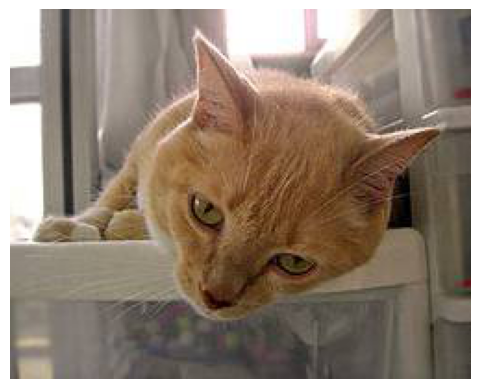

In [20]:
image_path = glob.glob(f"./datasets/dogs-vs-cats/processed/train/{cls}/*.jpg")[5]

with Image.open(image_path) as f:
    plt.imshow(f) 
    plt.axis("off")

How cute! Now, let's randomly flip this image horizontally. The 'randomly' part ensures that the flip won't happen every time, adding diversity to our dataset.

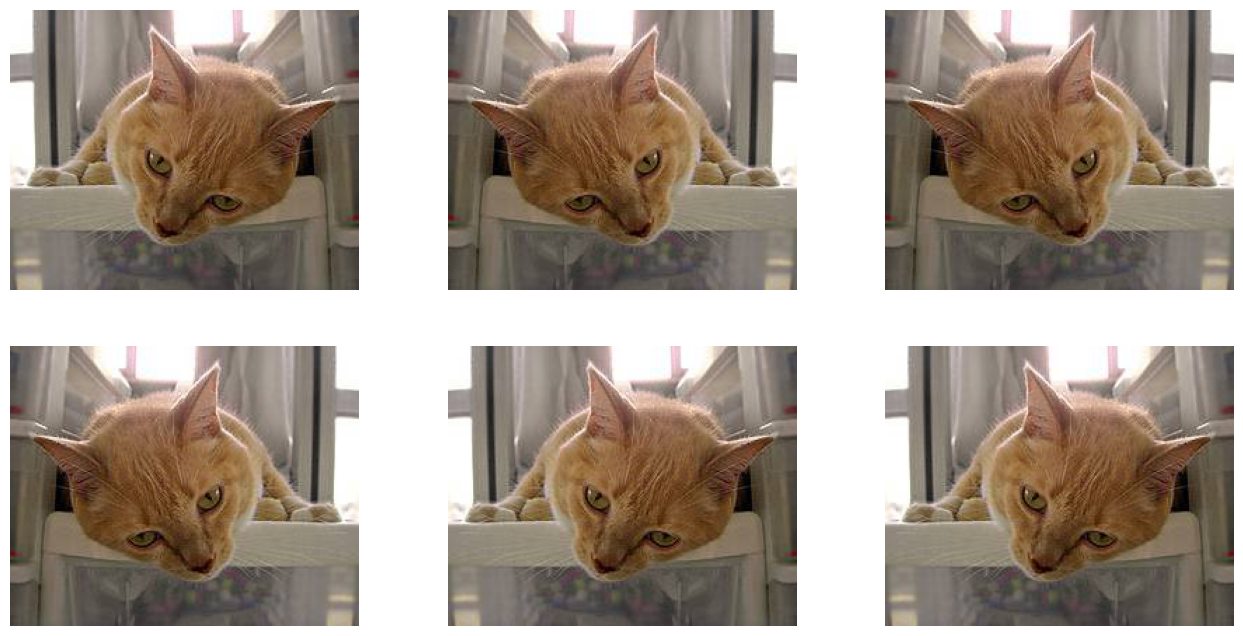

In [21]:
fig = plt.figure(figsize=(16,8))
for i in range(6):
    plt.subplot(2,3, i + 1)
    flipped = transforms.RandomHorizontalFlip(.5)(f)

    plt.imshow(flipped)
    plt.axis('off')
plt.show()

Similarly, we can randomly rotate it a bit (10 degrees).

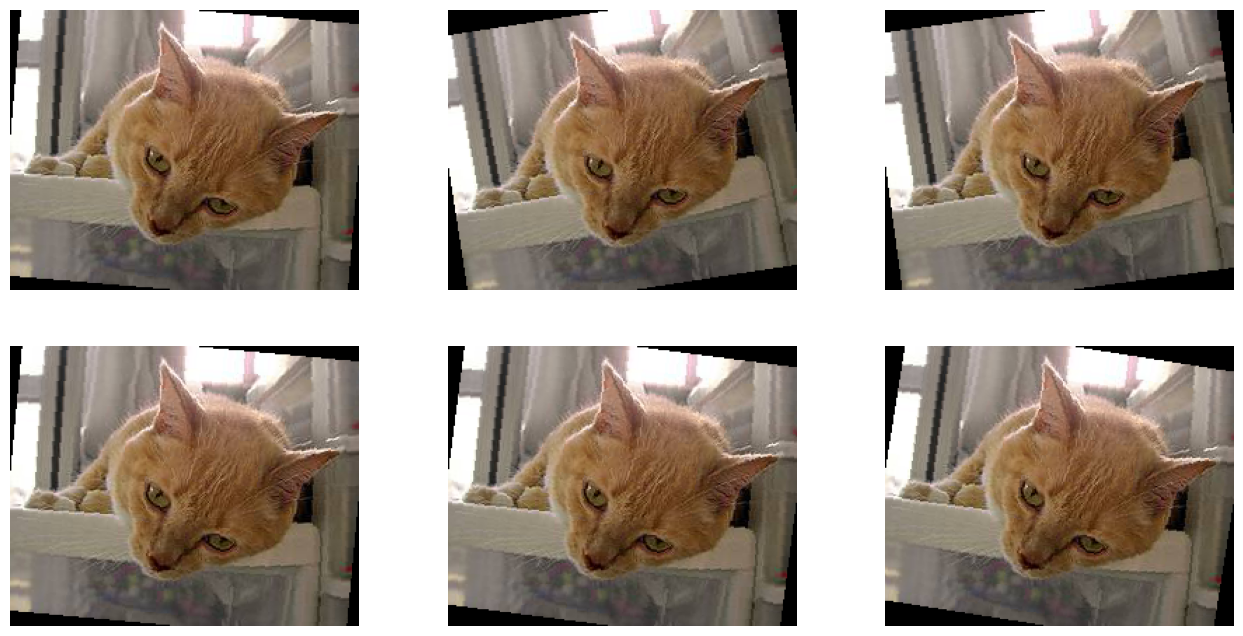

In [22]:
fig = plt.figure(figsize=(16,8))
for i in range(6):
    plt.subplot(2,3, i + 1)
    flipped = transforms.RandomRotation(10)(f)

    plt.imshow(flipped)
    plt.axis('off')
plt.show()

We can combine multiple image augmentation techniques using `transforms.Compose`. This allows us to apply a sequence of transformations to the image, enhancing its variability. Let's see how we can string up these techniques together in a transformation pipeline.

In [23]:
autmentation_transforms = transforms.Compose([
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(.5),
    transforms.Resize(size=(180, 180)),
    transforms.CenterCrop(size=(96, 96)),
    transforms.ToTensor()
])

Let's call these transformations a couple of times on the above image and plot the results:

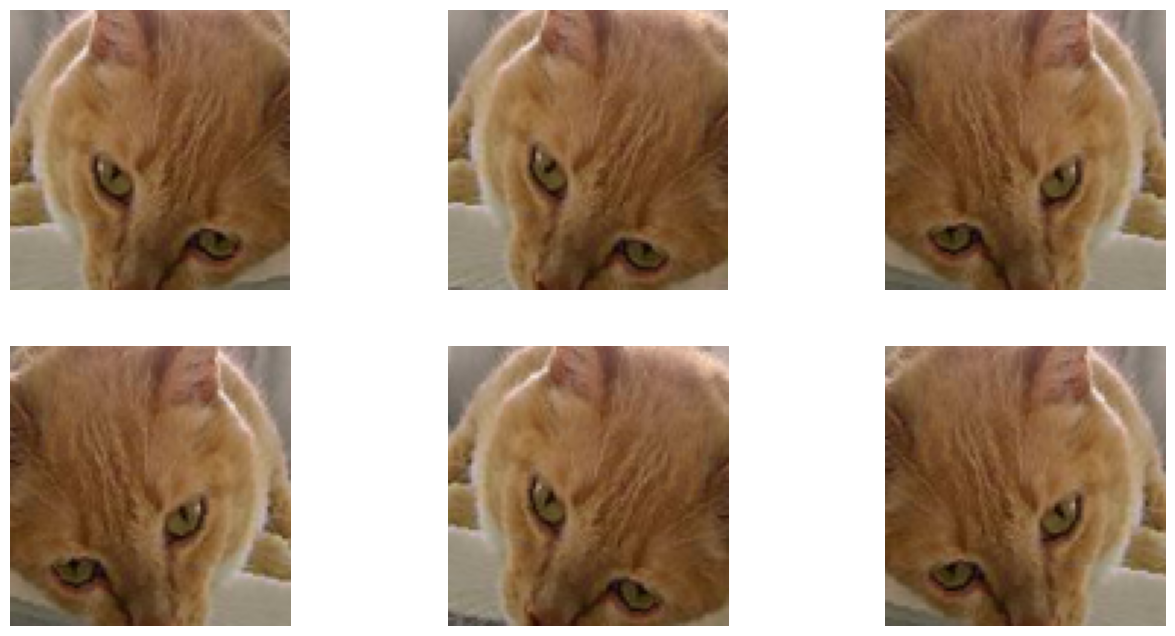

In [24]:
fig = plt.figure(figsize=(16,8))
for i in range(6):
    plt.subplot(2,3, i + 1)
    transformed = autmentation_transforms(f)

    plt.imshow(transformed.permute(1, 2, 0))
    plt.axis('off')
plt.show()

To use these new transformations, we create a new data module object and pass it the new transformations.

In [25]:
augmented_dogs_vs_cats_dm = DogsVsCatsDataModule(train_transform=autmentation_transforms)

Now, let's train a new instance of the above ConvNet using the augmented data module. This, again, will allow us to leverage the benefits of image augmentation for a more robust and generalized model.

In [26]:
model = DogsVsCatsModelV01()

trainer = L.Trainer(max_epochs=5)
trainer.fit(model=model, datamodule=augmented_dogs_vs_cats_dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name           | Type               | Params
------------------------------------------------------
0 | train_accuracy | MulticlassAccuracy | 0     
1 | val_accuracy   | MulticlassAccuracy | 0     
2 | test_accuracy  | MulticlassAccuracy | 0     
3 | model          | Sequential         | 1.3 M 
------------------------------------------------------
1.3 M     Trainable params
0         Non-trainable params
1.3 M     Total params
5.167     Total estimated model params size (MB)


Skipping, found downloaded files in "./datasets/dogs-vs-cats" (use force=True to force download)
Skipping! datasets/dogs-vs-cats/processed already exists.


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=5` reached.


Finally, we evaluate the trained model:

In [27]:
trainer.test(model, dataloaders=dogs_vs_cats_dm)

Skipping, found downloaded files in "./datasets/dogs-vs-cats" (use force=True to force download)
Skipping! datasets/dogs-vs-cats/processed already exists.


Testing: |                                                                                                    …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.7406666874885559     │
│         test_loss         │     0.530965268611908     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.530965268611908, 'test_accuracy': 0.7406666874885559}]

### Using residual connections

Residual connections, introduced by He et al. in 2015, are a crucial component of modern ConvNets. They, along with batch normalization and dropout, enable the construction of deep networks without encountering the issue of vanishing gradients.

The pseudo-code for a residual connection looks like this:

   ```
   x = ...                 
   residual = x            
   x = block(x)            
   x = add(x, residual) 
   ...
   ```

   This can be depicted as follows:

   ```
              x
              │
              │───────────────┐
              │               │
              ▼               │
      ┌───────────────┐       │
      │     Block     │       │
      └───────────────┘       │
              │               │      
              +◄──────────────┘
              │
              ▼
            new x 
   ```

Adding the residual to the output of the block can be tricky since both arguments to the `add` layer might not have the same shape. To address this issue, we pass the `residual` through a convolution layer with a 1 by 1 filter to ensure it matches the shape of `x`. The stride of this 1 by 1 convolution will depend on whether pooling is used or not.

Here is a model with three residual blocks, incorporating image augmentation. But, instead of running this model piece by piece inside this notebook, we'll create a Python program and run it in the terminal. 

First, run the following cell, which will save the code below to a file named `model_res_dogs_vs_cats.py`. This is to show you how real-world PyTorch models are actually built and trained. They are coded into Python programs with a main function like this and executed from the command line. All the imports and classes are included. At the bottom, there is a main function snippet:

   ```python
   if __name__ == "__main__":
       main()
   ```
This tells Python where to start when the program runs.

In [28]:
%%file model_res_dogs_vs_cats.py

import numpy as np
import pandas as pd
import os, shutil, pathlib
import torch
import torch.nn as nn
import torch.functional as F
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
import lightning as L
from torchmetrics import Accuracy
from torch.utils.data import random_split, DataLoader
from torchinfo import summary
from torchviz import make_dot
import matplotlib.pyplot as plt
from torchmetrics import Accuracy
import opendatasets as od

class DogsVsCatsDataModuleV02(L.LightningDataModule):
    def __init__(self, data_path='./datasets', transforms = transforms.Compose([
            transforms.Resize(size=(128, 128)),
            transforms.ToTensor()
        ])):
        super().__init__()

        self.data_path = data_path
        self.transforms = transforms

    def make_subset(self, subset_name, start_index, end_index):
        for category in ("cat", "dog"):
            dir = self.dest_dir / subset_name / category
            os.makedirs(dir)
            fnames = [ f"{category}.{i}.jpg" for i in range(start_index, end_index) ]
            for fname in fnames:
                shutil.copyfile(src=self.src_dir / fname, dst=dir / fname)
                        
    def prepare_data(self):
        dataset_url = 'https://www.kaggle.com/c/dogs-vs-cats/data'
        od.download(dataset_url, data_dir=self.data_path)
        
        self.src_dir = pathlib.Path(self.data_path + "/dogs-vs-cats/train")
        self.dest_dir = pathlib.Path(self.data_path + "/dogs-vs-cats/processed")
        
        if not os.path.exists(self.dest_dir):
            self.make_subset("train", start_index=0, end_index=8000)
            self.make_subset("validation", start_index=8000, end_index=9500)
            self.make_subset("test", start_index=9500, end_index=11000)
        else:
            print("Skipping!", self.dest_dir, "already exists.")
            
    def setup(self, stage=None):
        self.target_transform = transforms.Lambda(lambda y: torch.tensor([y]).float())
        
        self.ds_train = datasets.ImageFolder(f"{self.dest_dir}/train", transform=self.transforms) 
        self.ds_val = datasets.ImageFolder(f"{self.dest_dir}/validation", transform=self.transforms)
        self.ds_test = datasets.ImageFolder(f"{self.dest_dir}/test", transform=self.transforms)

    def train_dataloader(self):
        return DataLoader(self.ds_train, batch_size=128, num_workers=4, shuffle=True, persistent_workers=True, drop_last=True)

    def val_dataloader(self):
        return DataLoader(self.ds_val, batch_size=128, num_workers=4, persistent_workers=True)

    def test_dataloader(self):
        return DataLoader(self.ds_test, batch_size=128, num_workers=4, persistent_workers=True)

class ResidualBlock(nn.Module):
    def __init__(self, in_filters, out_filters, pooling=False):
        super().__init__()
        self.pooling = pooling
        self.in_filters = in_filters
        self.out_filters = out_filters
        self.conv1 = nn.Conv2d(in_filters, out_filters, kernel_size=3, padding="same")
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_filters, out_filters, kernel_size=3, padding="same")
        if self.pooling:
            self.pool = nn.MaxPool2d(kernel_size=2)
            self.residual = nn.Conv2d(self.in_filters, self.out_filters, kernel_size=3, stride=2, padding=1)
        else:
            self.residual = nn.Conv2d(self.in_filters, self.out_filters, kernel_size=3, padding=1)
        

    def forward(self, x):
        out = self.relu(self.conv1(x))
        out = self.relu(self.conv2(out))
        if self.pooling:
            out = self.pool(out)
        residual = self.residual(x)
            
        out = out + residual
            
        return out
        
class DogsVsCatsModelV02(L.LightningModule):
    def __init__(self, lr=0.001):
        super().__init__()
        self.lr = lr
        
        self.train_accuracy = Accuracy(task="multiclass", num_classes=2)
        self.val_accuracy = Accuracy(task="multiclass", num_classes=2)
        self.test_accuracy = Accuracy(task="multiclass", num_classes=2)
        
        self.model = nn.Sequential(
            ResidualBlock(3, 32, True),
            ResidualBlock(32, 64, True),
            ResidualBlock(64, 128, False),
            nn.Flatten(),
            nn.Dropout1d(p=.5),
            nn.Linear(128 * 32 * 32, 32),
            nn.ReLU(),
            nn.Linear(32, 2),
        )

    def forward(self, x):
        return self.model(x)

    def _common_step(self, batch, batch_idx, accuracy, loss_lbl, accuracy_lbl):
        X, y = batch
        logits = self(X)
        loss = nn.functional.cross_entropy(logits, y)
        y_hat = torch.argmax(logits, dim=1)
        self.log(loss_lbl, loss, prog_bar=True)
        self.log(accuracy_lbl, accuracy(y_hat, y), prog_bar=True)
        return loss

    def training_step(self, batch, batch_idx):
        return self._common_step(batch, batch_idx, self.train_accuracy, "loss", "accuracy")

    def on_training_epoch_end(self):
        self.log("accuracy", self.train_accuracy.compute())
        self.train_accuracy.reset()
    
    def validation_step(self, batch, batch_idx):
        return self._common_step(batch, batch_idx, self.val_accuracy, "val_loss", "val_accuracy")

    def on_validation_epoch_end(self):
        self.log("val_accuracy", self.val_accuracy.compute())
        self.val_accuracy.reset()

    def test_step(self, batch, batch_idx):
        return self._common_step(batch, batch_idx, self.test_accuracy, "test_loss", "test_accuracy")

    def on_test_epoch_end(self):
        self.log("test_accuracy", self.test_accuracy.compute())
        self.test_accuracy.reset()
        
    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=self.lr)

def main():
    torch.random.manual_seed(17);
    model = DogsVsCatsModelV02()
    dogs_vs_cats_dm = DogsVsCatsDataModuleV02()
    
    summary(model)

    trainer = L.Trainer(max_epochs=5)
    trainer.fit(model=model, datamodule=dogs_vs_cats_dm)
    
    trainer.test(model, dataloaders=dogs_vs_cats_dm)

if __name__ == "__main__":
    main()


Overwriting model_res_dogs_vs_cats.py


To run this program, open a Terminal (File/New/Terminal) and execute the following command:

```bash
python3 ./model_res_dogs_vs_cats.py
```

Ensure that you are in the correct directory or adjust the path accordingly. Running this command will execute the program, which will build, train, and evaluate its model.

## Cancer tissue detection

In this example, we will use a modified version of the Pcam dataset, also known as the PatchCamelyon dataset. It is widely used in the field of digital pathology for cancer detection. Created by researchers from the Radboud University Medical Center in the Netherlands, it is designed for image classification tasks, with a specific focus on detecting metastatic cancer in lymph node tissue sections. The dataset comprises histopathological images of lymph node sections stained with hematoxylin and eosin (H&E). These images are typically utilized in the diagnosis of breast cancer.

While the original PCam dataset contains duplicate images, the version we'll be using is from Kaggle and does not contain duplicates. This dataset is also part of a competition, so you'll need to join the competition and accept its rules before you can download it.

### Fetching the data

Let's proceed to download the data:

In [29]:
dataset_url = 'https://www.kaggle.com/c/histopathologic-cancer-detection'
od.download(dataset_url, data_dir='./datasets')

Skipping, found downloaded files in "./datasets/histopathologic-cancer-detection" (use force=True to force download)


This dataset includes two folders: `train` and `test`. Additionally, there is a CSV file named `train_labels.csv` that associates image names with their corresponding classes. The classes, or labels, are either 0 for normal or 1 for abnormal (cancerous). Let's read these labels:

In [30]:
data_path = 'datasets/histopathologic-cancer-detection'
cancer_labels = pd.read_csv(data_path + '/train_labels.csv')
cancer_labels.head()

id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0

Additionally, let's print the count of images for each class. This will help us determine whether the dataset is balanced.

In [31]:
cancer_labels['label'].value_counts()

0    130908
1     89117
Name: label, dtype: int64

As you can see, there are 130,908 normal cases (0) and 89,117 abnormal (cancerous) cases (1), indicating that the dataset is not highly unbalanced.

Now, let's print the number of images in each of the `train` and `test` folders:

In [32]:
print('Training:', len(os.listdir(data_path + "/train")), "images")
print('Testing:  ', len(os.listdir(data_path + "/test")), "images")

Training: 220025 images
Testing:   57458 images


To see what these images look like, Let's select few random training images:

In [33]:
all_images = os.listdir(pathlib.Path(data_path + "/train"))

sample_images = [
    all_images[img] for img in torch.randperm(len(all_images))[:32]]
len(sample_images)

32

and let's plot them:

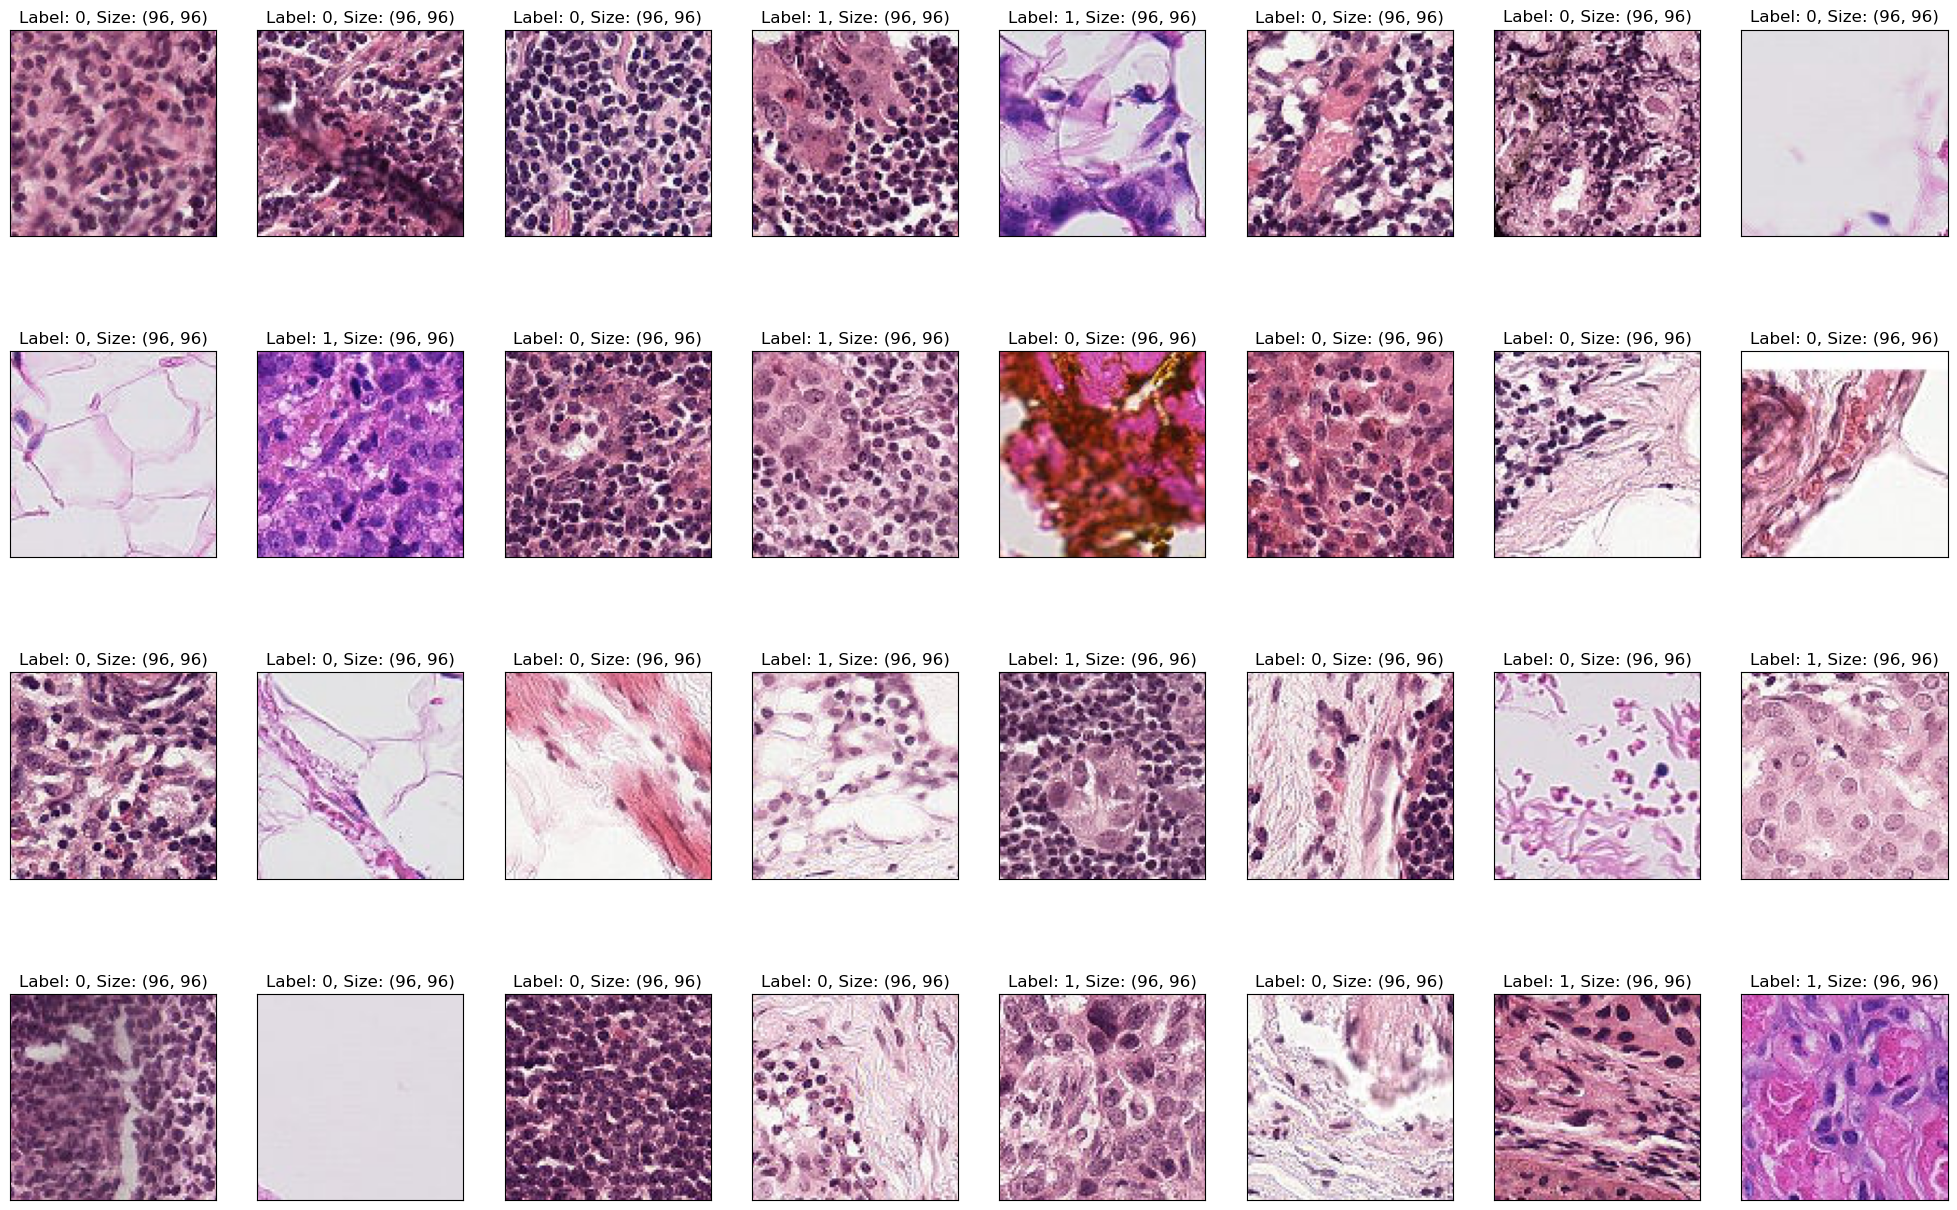

In [34]:
fig = plt.figure(figsize=(25, 16))
for idx, name in enumerate(sample_images):
    ax = fig.add_subplot(4, 32//4, idx+1, xticks=[], yticks=[])
    img = Image.open(data_path + "/train/" + name)
    plt.imshow(img)
    label = cancer_labels.loc[cancer_labels['id'] == name.split('.')[0], 'label'].values[0]
    ax.set_title(f'Label: {label}, Size: {img.size}')

As you can see, these are color images with a standard size of 96 by 96 pixels.

### Processing the Dataset

Due to the considerable size of this dataset and the extensive computational resources required for training, we'll simplify this example by using only a sample of 20,000 training images. These will be split into training, validation, and testing subsets.

According to Kaggle, 'A positive label indicates that the center 32x32px region of a patch contains at least one pixel of tumor tissue. Tumor tissue in the outer region of the patch does not influence the label. This outer region is provided to enable the design of fully-convolutional models that do not use any zero-padding, ensuring consistent behavior when applied to a whole-slide image.'

This means we need to crop these images from the center and keep only a 32 by 32 region. This can be achieved using `torchvision.transforms` like this:

In [35]:
transform = transforms.Compose([
    transforms.CenterCrop(32),
    transforms.ToTensor()
])

We will use these transforms for both validation and testing. For training, we add a few extra image augmentation transforms like this:

In [36]:
train_transform = transforms.Compose([
    transforms.CenterCrop(32),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
])

We are now ready to create the datasets. For that, we randomly pick 20,000 images from under the `train` folder and copy them to a new folder named `processed`, organizing them in a directory structure like this:

```
- datasets
    - histopathologic-cancer-detection
        - processed
            - train
                - 0_normal
                    ...files go here ...
                - 1_abnormal
                    ...files go here ...
            - validation
                - 0_normal
                    ...files go here ...
                - 1_abnormal
                    ...files go here ...
            - test
                - 0_normal
                    ...files go here ...
                - 1_abnormal
                    ...files go here ...

```

This is the same familiar directory structure we saw in the dogs vs cats example above. Here is a function that creates and copies the images of a data subset. 

In [37]:
def make_subset(subset, start_index, end_index, images, labels):
    categories = {0: "0_normal", 1: "1_abnormal" }
    for i in range(start_index, end_index):
        category = categories[labels[i]]
        dir = dest_dir / subset / category
        os.makedirs(dir, exist_ok=True)
        fname = f"{images[i]}.tif"
        shutil.copyfile(src=src_dir / fname, dst=dir / fname)

Next, we randomized the images under the `train` folder, select only 20,000 of them, and get their labels.

In [38]:
data_path = './datasets/histopathologic-cancer-detection'
labels = pd.read_csv(data_path + '/train_labels.csv')
labels = labels.set_index('id')

src_dir = pathlib.Path(data_path + "/train")
dest_dir = pathlib.Path(data_path + "/processed")

train_image_files = os.listdir(src_dir)
selected_images = [
    train_image_files[f].split('.')[0] 
    for f in torch.randperm(len(train_image_files))[:20000]
]

selected_labels = labels.loc[selected_images]['label'].values

len(selected_images), len(selected_labels)

(20000, 20000)

Having done that, we can now create training, validation, and testing subsets under the `processed` folder. This step will be skipped if it has already been done. We'll allocate 16,000 images for training, and 2,000 images each for validation and testing:

In [39]:
if not os.path.exists(dest_dir):
    make_subset("train", 0, 16000, selected_images, selected_labels)
    make_subset("validation", 16000, 18000, selected_images, selected_labels)
    make_subset("test", 18000, 20000, selected_images, selected_labels)
else:
    print("Skipping!", dest_dir, "already exists.")

Skipping! datasets/histopathologic-cancer-detection/processed already exists.


Let's create the datasets. We'll use the `torchvision.datasets.ImageFolder` class along with the above transformations for that.

In [40]:
ds_train = datasets.ImageFolder(f"{dest_dir}/train", transform=train_transform) 
ds_val = datasets.ImageFolder(f"{dest_dir}/validation", transform=transform)
ds_test = datasets.ImageFolder(f"{dest_dir}/test", transform=transform)

len(ds_train), len(ds_val), len(ds_val)

(16000, 2000, 2000)

Here are the corresponding data loaders:

In [41]:
dl_train = DataLoader(ds_train, batch_size=256, num_workers=4, 
                      shuffle=True, persistent_workers=True, 
                      drop_last=True, pin_memory=True)
dl_val = DataLoader(ds_val, batch_size=256, num_workers=4, 
                    persistent_workers=True, pin_memory=True)
dl_test = DataLoader(ds_test, batch_size=256, num_workers=4, 
                     persistent_workers=True, pin_memory=True)

To see the newly transformed images, let's plot the first 32 images from the initial batch of the training data:

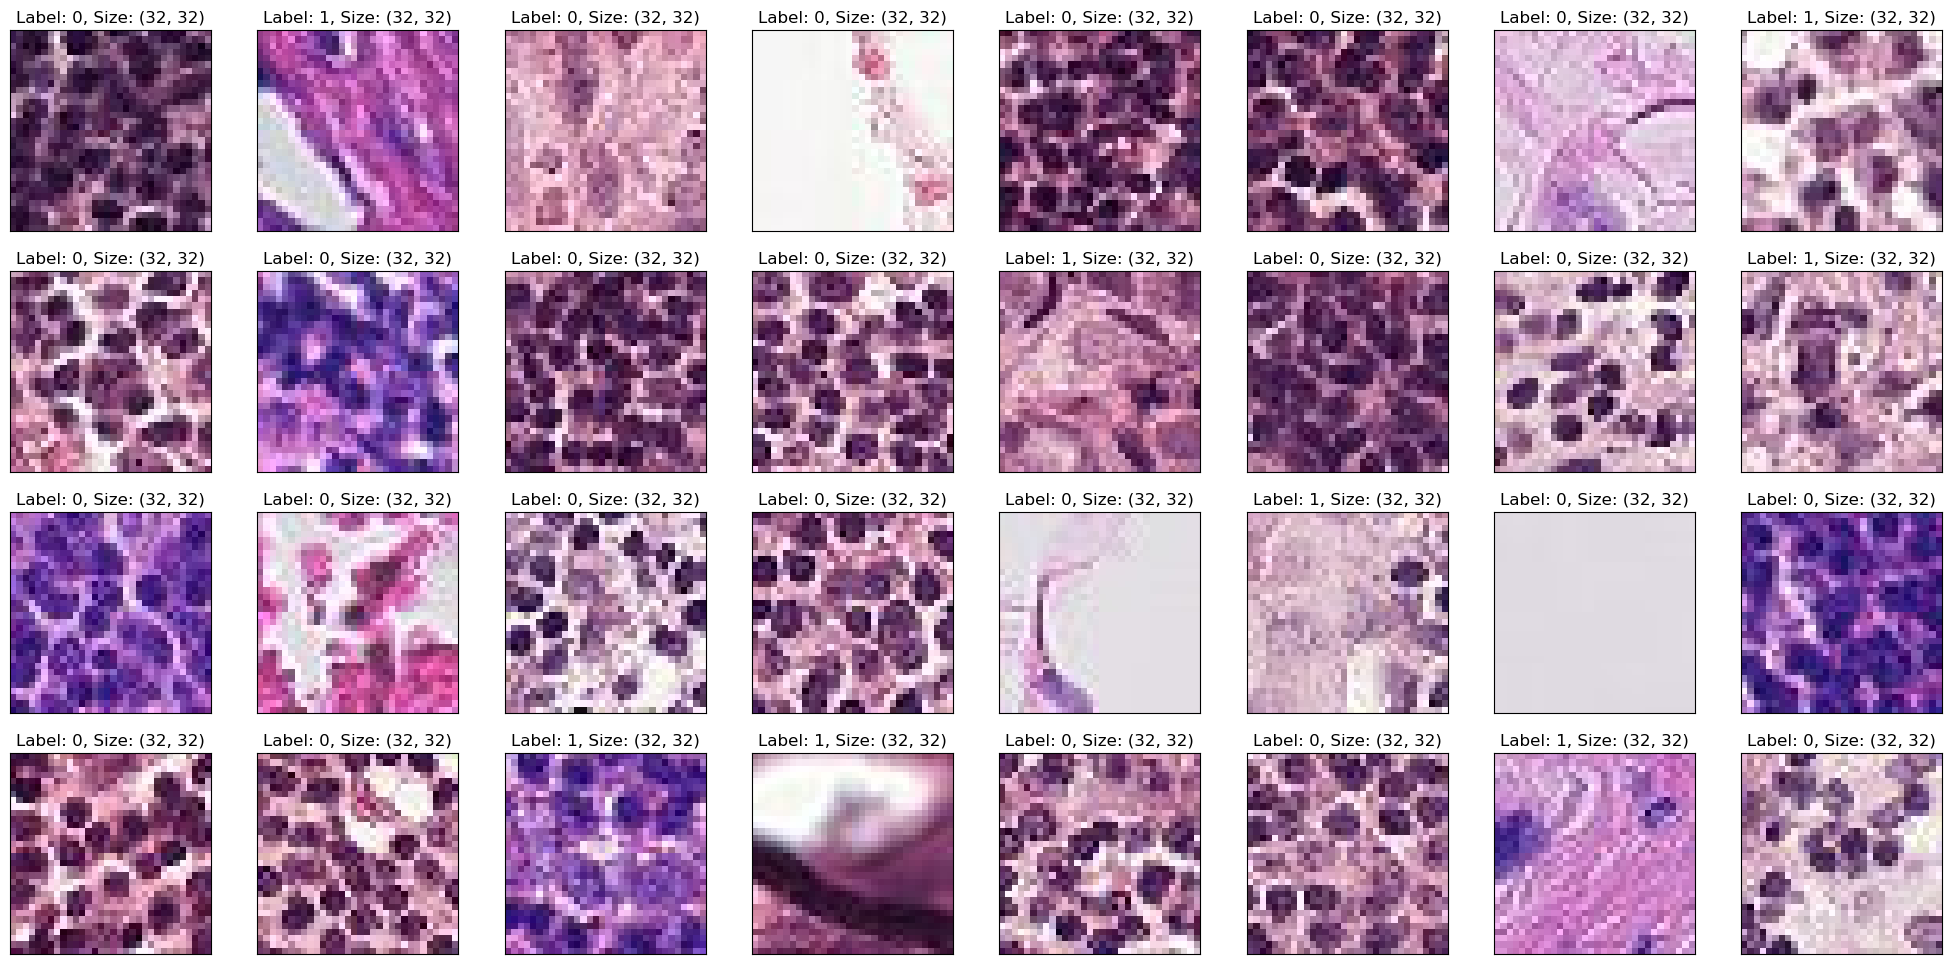

In [42]:
fig = plt.figure(figsize=(25, 12))

for X, y in dl_train:
    for i in range(32):
        ax = fig.add_subplot(4, 32//4, i+1, xticks=[], yticks=[])
        plt.imshow(X[i].permute(1, 2, 0)) 
        size = (X[i].shape[1], X[i].shape[2])
        ax.set_title(f'Label: {y[i]}, Size: {size}')
    break

### Building and training the model

We are now ready to build a ConvNet. We'll implement a simple one, just for demonstration.

In [43]:
class CancerImageClassifier(BaseModule):
    def __init__(self):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Conv2d(16, 32, kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Flatten(),
            nn.Dropout1d(p=.5),
            nn.Linear(8192, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        return self.model(x)


model = CancerImageClassifier()

Here is a summary of it:

In [44]:
summary(model)

Layer (type:depth-idx)                   Param #
CancerImageClassifier                    --
├─MulticlassAccuracy: 1-1                --
├─MulticlassAccuracy: 1-2                --
├─MulticlassAccuracy: 1-3                --
├─Sequential: 1-4                        --
│    └─Conv2d: 2-1                       448
│    └─BatchNorm2d: 2-2                  32
│    └─ReLU: 2-3                         --
│    └─MaxPool2d: 2-4                    --
│    └─Conv2d: 2-5                       4,640
│    └─BatchNorm2d: 2-6                  64
│    └─ReLU: 2-7                         --
│    └─Flatten: 2-8                      --
│    └─Dropout1d: 2-9                    --
│    └─Linear: 2-10                      4,194,816
│    └─ReLU: 2-11                        --
│    └─Linear: 2-12                      131,328
│    └─ReLU: 2-13                        --
│    └─Linear: 2-14                      16,448
│    └─ReLU: 2-15                        --
│    └─Linear: 2-16                      130
Total 

And here is a plot of it:

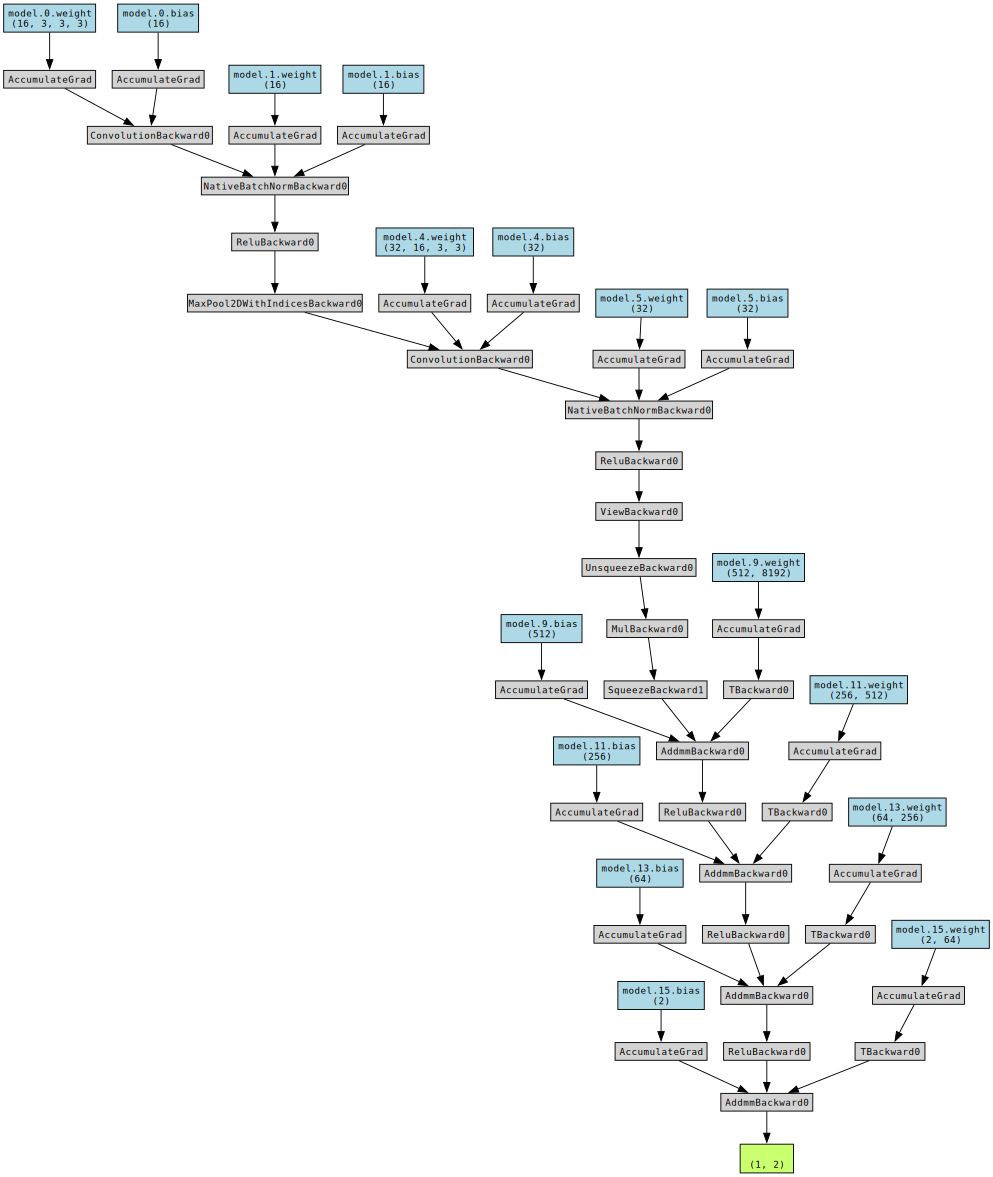

In [45]:
make_dot(model(torch.ones(1, 3, 32, 32)), params=dict(model.named_parameters()))

Let's train this model using model checkpoint and early stopping callbacks.

In [46]:
from lightning.pytorch.callbacks import ModelCheckpoint, EarlyStopping

callbacks = [
    ModelCheckpoint(
        monitor='val_loss',     # Metric to monitor for saving the best model
        mode='min',             # Indicate a minimization process
        save_last=True,         # Save the last checkpoint (useful for resuming training)
        save_top_k=1,           # Save the top k models based on the monitored metric
        dirpath='checkpoints/', # Directory to save the checkpoints to
        filename='cancer-{epoch:02d}-{val_loss:.2f}',  # Name of saved checkpoints
    ),
    EarlyStopping(
        monitor='val_loss',     # Metric to monitor for early stopping
        patience=3,             # How many epochs with no improvement before training is stopped
        mode='min',             # Indicate a minimization process monitored metric
    )
]

trainer = L.Trainer(max_epochs=10, callbacks=callbacks)
trainer.fit(model, train_dataloaders=dl_train, val_dataloaders=dl_val)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/aalgahmi/opt/miniconda3/envs/torch/lib/python3.11/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:639: Checkpoint directory checkpoints/ exists and is not empty.

  | Name           | Type               | Params
------------------------------------------------------
0 | train_accuracy | MulticlassAccuracy | 0     
1 | val_accuracy   | MulticlassAccuracy | 0     
2 | test_accuracy  | MulticlassAccuracy | 0     
3 | model          | Sequential         | 4.3 M 
------------------------------------------------------
4.3 M     Trainable params
0         Non-trainable params
4.3 M     Total params
17.392    Total estimated model params size (MB)


Sanity Checking: |                                                                                            …

Training: |                                                                                                   …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=10` reached.


As you can see, the early stopping callback intervened (or might intervene), preventing the completion of all 10 epochs. Now, let's evaluate this model using the best saved checkpoint:

In [47]:
trainer.test(ckpt_path='best', dataloaders=dl_test)

Restoring states from the checkpoint path at checkpoints/cancer-epoch=08-val_loss=0.50-v1.ckpt
Loaded model weights from the checkpoint at checkpoints/cancer-epoch=08-val_loss=0.50-v1.ckpt


Testing: |                                                                                                    …

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.7960000038146973     │
│         test_loss         │    0.48638296127319336    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.48638296127319336, 'test_accuracy': 0.7960000038146973}]